# Binary Classification using Tensorflow

TensorFlow is a versatile framework for machine learning, capable of tackling diverse tasks, including binary classification. Using the Titanic dataset, the objective is to predict whether a passenger survived or not, based on features like:
- **Age**, **Gender**, **Passenger Class (Pclass)**, **Fare**, **Embarked Port**, and more.

### Key Steps in the Process

1. **Data Preprocessing**  
   - Cleaning and handling missing values.  
   - Encoding categorical variables (e.g., gender or embarkation ports).  
2. **Model Building**  
   - Designing a neural network specifically for binary classification.  
   - Using layers like Dense, Activation, and Dropout to create a flexible model.  
3. **Training and Evaluation**  
   - Leveraging TensorFlow's tools to train the model using labelled data.  
   - Evaluating its performance on unseen data to ensure generalisation.
------
We are going to do similar to the Regression Tensorflow workbook, but this time we are going to work at a classification problem

Back to the titanic.csv file we used before

In [40]:
# Import dependencies
import tensorflow as tf # TensorFlow - Main library for building and training neural networks
import pandas as pd # pandas - for data manipulation and handling structured datasets
import numpy as np # NumPy - support for numerical operations and working with arrays
import matplotlib.pyplot as plt # Matplotlib - for visualizing data and model performance
from sklearn.model_selection import train_test_split # utility from scikit-learn to split data into training and test sets

# Print TensorFlow version to confirm installation and compatibility
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


### Read and Clean Data

To prepare the dataset for modelling, we'll follow these steps:

1. **Read in the data**: Load the Titanic dataset using a suitable library (e.g., `pandas`).
2. **Handle missing values**:
   - Remove rows where the `Embarked` column is not filled.
   - Fill in missing values in the `Age` column with the median age.
3. **Select relevant features**:
   - Identify and keep only the columns required for building the model.
4. **Encode categorical variables**:
   - Use a `LabelEncoder` to convert the `Sex` column from text (e.g., "male", "female") to numbers.
   - Use a `OneHotEncoder` to encode the `Embarked` column into multiple binary columns (one per embarkation point).


In [41]:
# Read and clean Data ----------
# Load Titanic dataset
df = pd.read_csv("titanic.csv")
# Remove rows with missing 'Embarked' values and fill missing 'Age' with the median
df = df[df["Embarked"].notnull()]
df['Age'] = df['Age'].fillna(df['Age'].median())
# Define target variable 'y' (Survived) and features 'X'
y = df["Survived"]
X = df[["Pclass", "Age", "Sex", "SibSp", "Parch", "Fare", "Embarked"]]

Convert sex to numeric values using label encoder from preprocessing library

In [42]:
from sklearn import preprocessing

# Encode the 'Sex' column using LabelEncoder
le_sex = preprocessing.LabelEncoder()  # Initialize the encoder
le_sex.fit(X['Sex'])                   # Fit the encoder on the 'Sex' column
sex = le_sex.transform(X['Sex'])       # Transform 'Sex' into numerical values (e.g., 0 for male, 1 for female)

# Replace the original 'Sex' column with the encoded values
X = X.drop(['Sex'], axis=1)  # Drop the original 'Sex' column
X['Sex'] = sex               # Add the encoded 'Sex' column back


Convert Embarked to numeric values using OneHotEncoder from preprocessing library. There's probably a better way of doing this but this'll work

In [43]:
from sklearn import preprocessing

# Encode the 'Embarked' column using OneHotEncoder
le_embark = preprocessing.OneHotEncoder(sparse_output=False)  # Initialize encoder with dense output
le_embark.fit(X["Embarked"].values.reshape(-1, 1))            # Fit encoder on the 'Embarked' column
embarked = le_embark.transform(X["Embarked"].values.reshape(-1, 1))  # Transform 'Embarked' into one-hot vectors

# Replace the original 'Embarked' column with one-hot encoded columns
X = X.drop(["Embarked"], axis=1)      # Drop the original 'Embarked' column
X["EmbarkC"] = embarked[:, 0]         # Add column for 'C' (Cherbourg)
X["EmbarkQ"] = embarked[:, 1]         # Add column for 'Q' (Queenstown)
X["EmbarkS"] = embarked[:, 2]         # Add column for 'S' (Southampton)
X  # Display the updated DataFrame

,Pclass,Age,SibSp,Parch,Fare,Sex,EmbarkC,EmbarkQ,EmbarkS
0,3,22.0,1,0,7.2500,1,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,1,0.0,0.0,1.0
887,1,19.0,0,0,30.0000,0,0.0,0.0,1.0
888,3,28.0,1,2,23.4500,0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1,1.0,0.0,0.0


### Machine Learning Process

Now we can proceed with the Machine Learning workflow. The steps include:

1. **Train-Test Split**: Divide the dataset into training and testing sets to evaluate model performance on unseen data.
2. **Normalise the Data**: Scale the features to ensure consistent ranges, improving model convergence during training.
3. **Build Base Models**: Define initial neural network architectures for binary classification.
4. **Compile**: Configure the model with an optimiser, loss function, and evaluation metrics.
5. **Fit**: Train the model on the training data, adjusting weights based on the loss function.
6. **Evaluate**: Test the model on the test set to assess its performance.

These steps follow the typical train-test split approach to ensure fair evaluation and generalisation of the model.


In [44]:
# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138, train_size=0.8)

Normalisation like was done on the Regression workbook

In [45]:
###Error### >from tensorflow.keras.layers.experimental import preprocessing<
# The tensorflow.keras.layers.experimental.preprocessing module has been deprecated in recent TensorFlow versions. 

# The Normalization layer is now part of tensorflow.keras.layers. Here's the corrected code:
from tensorflow.keras.layers import Normalization
# Initialize the Normalization layer
normalizer = Normalization()
# Adapt the normalizer to the training data (compute mean and variance)
normalizer.adapt(X_train.values)
# Apply normalization to the training data and print the result
print('Normalized:', normalizer(X_train.values).numpy())

Normalized: [[-1.5950363   0.1471719  -0.46338156 ... -0.4819084  -0.3198837
   0.6256112 ]
 [ 0.80765593 -1.572492   -0.46338156 ... -0.4819084  -0.3198837
   0.6256112 ]
 [ 0.80765593 -0.08732773 -0.46338156 ...  2.0750833  -0.3198837
  -1.5984368 ]
 ...
 [-1.5950363  -0.08732773 -0.46338156 ... -0.4819084  -0.3198837
   0.6256112 ]
 [ 0.80765593 -0.7126601  -0.46338156 ... -0.4819084  -0.3198837
   0.6256112 ]
 [-0.39369014 -2.1978242   1.3031831  ... -0.4819084  -0.3198837
   0.6256112 ]]


## Model Number 1 - Logistic Regression
We will begin with a simple Logistic Regression model as a baseline.
### Key Characteristics:
- Logistic Regression is a linear model used for binary classification.
- The output layer consists of **one unit** (neuron) with a sigmoid activation function to produce probabilities.
Mathematically, the model represents:
$$\log\left(\frac{p}{1-p}\right) = w^Tx + b$$
This formulation calculates the log-odds of the probability \(p\), where \(w\) represents the weights, \(x\) is the input data, and \(b\) is the bias term.
### TensorFlow Implementation:
- The model architecture will include a normalisation layer to scale the input data before applying the logistic regression layer.
- This approach is conceptually similar to using `sklearn`'s `LogisticRegression()`.

Including the normaliser as a layer ensures data is processed consistently during both training and inference.


In [46]:
# Define a Sequential model for logistic regression
model = tf.keras.Sequential([
    normalizer,  # Normalization layer to preprocess input data
    # Logistic regression layer
    tf.keras.layers.Dense(1)
])

# Display the model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (711, 9)               │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

### Understanding Model Output and Loss Function

1. **Trainable Parameters**:  
   - The model has **10 trainable parameters** because we have:
     - **9 features** (one weight for each feature).
     - **1 bias** term (\(b\)). (probability of survival if all weights are 0)

2. **Loss Function**:  
   - We use `BinaryCrossentropy` from TensorFlow because this is a binary classification problem.  
   - Documentation: [BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy).

3. **Using `from_logits`**:  
   - The `from_logits` parameter determines whether the output of the model is **logits** (unscaled values) or **probabilities** (scaled between 0 and 1).  
   - If no activation function is applied to the output layer (e.g., no `sigmoid`), the output is **logits**.  
     - In this case, set `from_logits=True`. This is **recommended** by TensorFlow for better numerical stability.  
   - If you apply a `sigmoid` activation in the output layer (e.g., `Dense(1, activation='sigmoid')`), the output will be probabilities.  
     - Here, set `from_logits=False`.

4. **Conclusion**:  
   - In the current implementation (`Dense(1)` without an activation), the model outputs logits, so you should use `from_logits=True` in the loss function.
   - If you decide to use `Dense(1, activation='sigmoid')`, update the loss function with `from_logits=False` (though TensorFlow recommends avoiding this setup for stability reasons).

**Key Tip**: Always align the `from_logits` parameter in the loss function with the activation used (or not used) in the model's output layer.


In [47]:
# Compile the model with optimizer, loss function, and evaluation metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),  # Adam optimizer with learning rate 0.1
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Binary cross-entropy loss with logits
    metrics=['accuracy']  # Track accuracy during training -- it must be in []
)

# Train the model on the training data for 100 epochs
model.fit(X_train, y_train, epochs=100)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5954 - loss: 0.7255  
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8116 - loss: 0.4490 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.4407 
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4359 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7859 - loss: 0.4941 
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.4201 
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8130 - loss: 0.4433 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7993 - loss: 0.4109 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.4404 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8115 - loss: 0.4372 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4432 
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

### Observations on Training Output

1. **Loss Decreasing**:  
   - The loss decreases consistently across epochs, indicating the model is learning from the training data. However, since no validation set is used, we cannot assess if the model is overfitting.

2. **Number of Epochs**:  
   - The model was trained for 100 epochs, which might be excessive or insufficient depending on the dataset. Using a validation set and monitoring metrics like validation loss can help determine an optimal number of epochs.

3. **Caution on `.fit`**:  
   - If you call `.fit` on the same model again, training will **continue from where it left off** (e.g., epoch 101 onwards), as the optimizer retains its state.  
   - To start training from scratch, you need to reinitialize the model or reset its weights.

4. **Improvements for Future Runs**:  
   - Use a **validation set** (e.g., via `validation_split` or a separate test set) to monitor performance and detect overfitting.
   - Implement **early stopping** to halt training once the validation loss stops improving, saving computation and avoiding overfitting.

5. **Accuracy Plateau**:  
   - Accuracy fluctuates slightly around a certain range (e.g., 0.81-0.83), which might indicate the model has reached its capacity with the given architecture and features.
   - Consider exploring hyperparameter tuning, additional features, or more complex models if further improvement is needed.


In [48]:
# Evaluate the logistic regression model on the test set
logRegEval = model.evaluate(X_test, y_test)

# Print the test loss and accuracy, rounded for readability
print("\nLogistic Regression Loss: ", round(logRegEval[0], 4), # logRegEval[0]: The loss from model.evaluate() rounded to 4 decimals.
      "Accuracy: ", round(logRegEval[1], 4)) # logRegEval[1]: The accuracy from model.evaluate() rounded to 4 decimals.

logRegEval # raw output loss first, accuracy second


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7484 - loss: 0.5401  

Logistic Regression Loss:  0.5054 Accuracy:  0.764


[0.5053704977035522, 0.7640449404716492]

### Output Analysis

**Accuracy**: 78.65%  
- Slightly lower than training (~83%), indicating mild overfitting.

**Loss**: 0.516  
- Moderate, showing predictions are reasonably close to true labels.

### Suggestions
- Use a validation set to monitor overfitting.
- Apply regularisation or tune hyperparameters.


## Model Number 2 - Neural Network

Next, we’ll build a more complex model: a Neural Network.

### Architecture:
- **4 layers**:
  - 3 hidden layers with **100 units** each.
  - **ReLU** activation function for non-linearity in the hidden layers.
  - 1 output layer for binary classification.
- This structure is flexible, and you can experiment with different configurations to optimise performance.

### Purpose:
This example demonstrates not only how to build a neural network using TensorFlow but also introduces techniques for customisation and experimentation with model architecture.

###### **Note:** `ReLU` stands for Rectified Linear Unit, and it's a commonly used activation function in neural networks. Unlike sigmoid or tanh, `ReLU` doesn’t squash values to a narrow range, reducing the likelihood of gradients becoming very small during backpropagation.


In [61]:
# Define a neural network model using TensorFlow's Sequential API
model_tf = tf.keras.Sequential([
    normalizer,  # Normalizes the input data (ensures mean=0 and variance=1)
    tf.keras.layers.Dense(100, activation='relu'),     # First hidden layer with 100 units and ReLU activation
    tf.keras.layers.Dense(100, activation='relu'),     # Second hidden layer with 100 units and ReLU activation
    tf.keras.layers.Dense(100, activation='relu'),     # Third hidden layer with 100 units and ReLU activation
    
    # Output layer with 1 unit for binary classification  # No activation function here (logits (raw output without conversion) will be used)
    tf.keras.layers.Dense(1)
])

In [ ]:
model_tf.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'],
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

model_tf.fit(X_train, y_train, epochs=100)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7309 - loss: 0.5923   
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.4341 
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.4112 
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8446 - loss: 0.3837 
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8393 - loss: 0.3977 
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8435 - loss: 0.3677 
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8457 - loss: 0.3559 
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8452 - loss: 0.3654 
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8387 - loss: 0.3520 
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8172 - loss: 0.3777 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8410 - loss: 0.3902 
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

Again Loss keeps decreasing (0.2355 min), haven't use a validation set though. Could've done a different number of epochs

In [ ]:
# how does my model look like
model_tf.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,924 (249.71 KB)

 Trainable params: 21,301 (83.21 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 42,604 (166.43 KB)

21301 trainable params, a lot more than the previous 10! Let's look at each layer

Input has 9 features Hidden Layer 1 has 100 units. Therefore the weight matrix is going to have 100 rows and 9 columns to match
$$ Wx + b $$

That gives us 900 paramaters for the weights. Then we have 100 biases - giving the total of 1000 parameters to go from input layer to hidden layer 1

Now from hidden layer 1 to hidden layer 2. 100 features, 100 units, gives us a 100x100 matrix so 10000 parameters, add in the 100 biases and we get the 10100

In [65]:
print("Logistic Regression Loss: ", round(logRegEval[0],4), "Accuracy: ", round(logRegEval[1],4))

Logistic Regression Loss:  0.5054 Accuracy:  0.764


In [64]:
annEval = model_tf.evaluate(X_test, y_test)
print("ANN Loss: ", round(annEval[0],4), "Accuracy: ", round(annEval[1],4))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7990 - loss: 1.0227  
ANN Loss:  0.986 Accuracy:  0.8034


These are potentially overfit, we should have done some validation to check over things

While the accuracy for the test data is better, the loss is actually worse!

## Using Validation
### Logistic Regression with Validation

Let's add in validation. kFold Cross Validation would be nice but that's more difficult to do with tensorflow and requires writing our own functions so let's just take the last 20% as a validation set. Since we used train_test_split already, the data is already shuffled so it should be ok

In [54]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [66]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    metrics=['accuracy'],
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6181 - loss: 0.7608 - val_accuracy: 0.8392 - val_loss: 0.4009
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7940 - loss: 0.4480 - val_accuracy: 0.8462 - val_loss: 0.4001
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8006 - loss: 0.4775 - val_accuracy: 0.8252 - val_loss: 0.3925
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8024 - loss: 0.4537 - val_accuracy: 0.8322 - val_loss: 0.4018
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7935 - loss: 0.4592 - val_accuracy: 0.8462 - val_loss: 0.3909
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8077 - loss: 0.4447 - val_accuracy: 0.8322 - val_loss: 0.3952
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8061 - loss: 0.4458 - val_accuracy: 0.8392 - val_loss: 0.3853
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7946 - loss: 0.4874 - val_accuracy: 0.8322 - 

Same function that was in the previous notebook

In [67]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

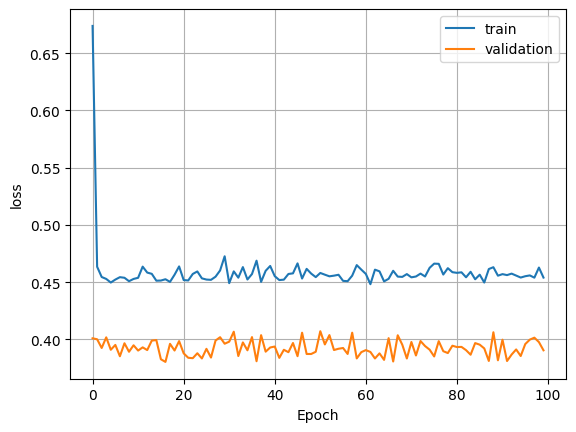

In [68]:
plot_loss(history)

In [69]:
logRegValidationEval = model.evaluate(X_test, y_test)
print("Logistic Regression with Validation Loss: ", round(logRegValidationEval[0],4), "Accuracy: ", round(logRegValidationEval[1],4))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7521 - loss: 0.5363 
Logistic Regression with Validation Loss:  0.4997 Accuracy:  0.7753


Seems about the same performance on the test set. Your numbers will vary due to SGD

Now ANN

### ANN with Validation

In [71]:
model_tf = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'],
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = model_tf.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7058 - loss: 0.5648 - val_accuracy: 0.8531 - val_loss: 0.3919
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8008 - loss: 0.4326 - val_accuracy: 0.8671 - val_loss: 0.3866
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8430 - loss: 0.3999 - val_accuracy: 0.8392 - val_loss: 0.4261
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8451 - loss: 0.3574 - val_accuracy: 0.8531 - val_loss: 0.3820
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8064 - loss: 0.3920 - val_accuracy: 0.8531 - val_loss: 0.4412
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8247 - loss: 0.3974 - val_accuracy: 0.8531 - val_loss: 0.3987
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.3752 - val_accuracy: 0.8671 - val_loss: 0.4299
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8437 - loss: 0.3671 - val_accuracy: 0.8601 - 

Let's plot the loss graph

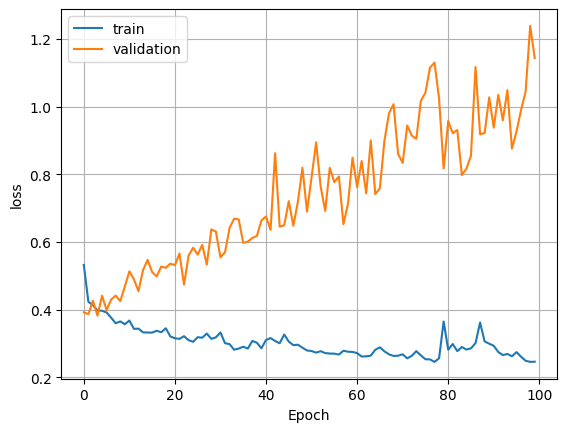

In [72]:
plot_loss(history)

Validation loss is a bit all over the place. This suggests overfitting to me

Neural Networks are not always better....even though the training loss and accuracy was better with the NN

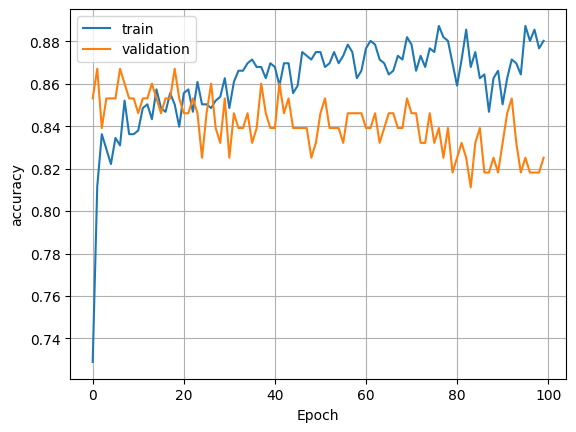

In [73]:
plot_loss(history, 'accuracy')

In [74]:
print("Logistic Regression with Validation Loss: ", round(logRegValidationEval[0],4), "Accuracy: ", round(logRegValidationEval[1],4))

Logistic Regression with Validation Loss:  0.4997 Accuracy:  0.7753


In [75]:
annValidationEval = model_tf.evaluate(X_test, y_test)
print("ANN with Validation Loss: ", round(annValidationEval[0],4), "Accuracy: ", round(annValidationEval[1],4))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8025 - loss: 1.3564 
ANN with Validation Loss:  1.3862 Accuracy:  0.8034


The NN did do better with the test set in terms of accuracy but loss quite a bit worse

## ANN with Regularisation

Ok, let's try smoothing some of that out with adding l2 regularisation to the layers

In [77]:
#Defining model with L2 regularisation
model_tf = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(100,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)
])

model_tf.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'],
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

history = model_tf.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6876 - loss: 1.9302 - val_accuracy: 0.8112 - val_loss: 0.7416
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8044 - loss: 0.6558 - val_accuracy: 0.8252 - val_loss: 0.5793
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8050 - loss: 0.5405 - val_accuracy: 0.8601 - val_loss: 0.4560
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7942 - loss: 0.5433 - val_accuracy: 0.8462 - val_loss: 0.4744
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8056 - loss: 0.5313 - val_accuracy: 0.8182 - val_loss: 0.5516
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8017 - loss: 0.5275 - val_accuracy: 0.8531 - val_loss: 0.4607
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7946 - loss: 0.4996 - val_accuracy: 0.8252 - val_loss: 0.4545
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8105 - loss: 0.4851 - val_accuracy: 0.8531 - 

val_loss: 0.4876 - val_accuracy: 0.8462 , so better than the last NN we build

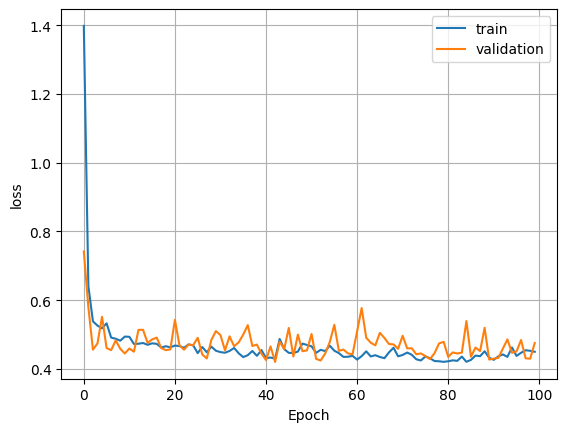

In [78]:
plot_loss(history)

That graph looks a lot better with some regularisation

In [79]:
model_tf.evaluate(X_test, y_test)
annValidationRegularisationEval = model_tf.evaluate(X_test, y_test)
print("ANN with Regularisation & Validation Loss: ", round(annValidationRegularisationEval[0],4), "Accuracy: ", round(annValidationRegularisationEval[1],4))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8094 - loss: 0.5751 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8094 - loss: 0.5751 
ANN with Regularisation & Validation Loss:  0.5507 Accuracy:  0.8202


In [80]:
print("Logistic Regression Loss: ", round(logRegEval[0],4), "Accuracy: ", round(logRegEval[1],4))
print("ANN Loss: ", round(annEval[0],4), "Accuracy: ", round(annEval[1],4))
print("Logistic Regression with Validation Loss: ", round(logRegValidationEval[0],4), "Accuracy: ", round(logRegValidationEval[1],4))
print("ANN with Validation Loss: ", round(annValidationEval[0],4), "Accuracy: ", round(annValidationEval[1],4))
print("ANN with Regularisation & Validation Loss: ", round(annValidationRegularisationEval[0],4), "Accuracy: ", round(annValidationRegularisationEval[1],4))

Logistic Regression Loss:  0.5054 Accuracy:  0.764
ANN Loss:  0.986 Accuracy:  0.8034
Logistic Regression with Validation Loss:  0.4997 Accuracy:  0.7753
ANN with Validation Loss:  1.3862 Accuracy:  0.8034
ANN with Regularisation & Validation Loss:  0.5507 Accuracy:  0.8202


Interesting to see that ANN doesn't do the best in terms of loss but does well in accuracy performace - shows that optimising for loss and accuracy are not the same thing. Also shows that a simpler model can sometimes be better choice